# Understanding Asynchronous Advantage Actor-Critic (A3C): A Complete Guide

### Important Note:

Since it is based on multiple workers, A3C is a bit more complex than A2C. It's better to implement it in a separate Python file. The Python file can be found with the name `a3c_training.py` in the same directory as this notebook. This notebook will only cover the theoretical aspects of A3C, while the implementation will be done in the `a3c_training.py` file.

# Table of Contents

- [Introduction](#introduction)
- [What is A3C?](#what-is-a3c)
  - [The Power of Asynchrony](#the-power-of-asynchrony)
  - [Advantages over A2C/Vanilla PG](#advantages-over-a2cvanilla-pg)
- [Where and How A3C is Used](#where-and-how-a3c-is-used)
- [Mathematical Foundation of A3C](#mathematical-foundation-of-a3c)
  - [Actor-Critic Recap](#actor-critic-recap)
  - [N-Step Returns](#n-step-returns)
  - [Asynchronous Gradient Updates](#asynchronous-gradient-updates)
  - [Shared vs. Local Networks](#shared-vs-local-networks)
  - [Loss Function (per Worker)](#loss-function-per-worker)
- [Step-by-Step Explanation of A3C (Worker Perspective)](#step-by-step-explanation-of-a3c-worker-perspective)
- [Key Components of A3C](#key-components-of-a3c)
  - [Global Actor Network](#global-actor-network)
  - [Global Critic Network](#global-critic-network)
  - [Worker Processes](#worker-processes)
  - [Local Actor-Critic Networks](#local-actor-critic-networks)
  - [Environment Instances](#environment-instances)
  - [N-Step Returns Calculation](#n-step-returns-calculation)
  - [Asynchronous Gradient Application](#asynchronous-gradient-application)
  - [Shared Optimizer (or Equivalent)](#shared-optimizer-or-equivalent)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the A3C Algorithm](#implementing-the-a3c-algorithm)
  - [Defining the Shared Actor-Critic Model](#defining-the-shared-actor-critic-model)
  - [N-Step Return and Advantage Calculation](#n-step-return-and-advantage-calculation)
  - [Defining the Worker Process](#defining-the-worker-process)
  - [Setting up Shared Optimizer (Simplified Approach)](#setting-up-shared-optimizer-simplified-approach)
- [Running the A3C Algorithm](#running-the-a3c-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization (Global Network, Shared Counter, Workers)](#initialization-global-network-shared-counter-workers)
  - [Training Execution (Starting & Joining Workers)](#training-execution-starting--joining-workers)
- [Visualizing the Learning Process (Challenges with Async)](#visualizing-the-learning-process-challenges-with-async)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in A3C](#common-challenges-and-solutions-in-a3c)
- [Conclusion](#conclusion)

## Introduction

Asynchronous Advantage Actor-Critic (A3C) was a landmark algorithm in deep reinforcement learning, demonstrating that parallel training with asynchronous updates could lead to stable and efficient learning across a variety of tasks. It builds directly on the actor-critic framework but introduces a novel way to achieve data decorrelation and training stability without relying on large replay buffers.

## What is A3C?

A3C is an **on-policy, asynchronous, actor-critic** algorithm. Its core idea is to run multiple 'worker' agents in parallel, each interacting with its own instance of the environment. These workers independently compute gradients based on their local experiences and asynchronously update a shared *global* set of actor and critic network parameters.

Key elements:
1.  **Parallel Workers:** Multiple independent processes (workers) are created.
2.  **Shared Global Network:** A single instance of the actor and critic networks exists globally, accessible by all workers.
3.  **Local Networks:** Each worker maintains its own local copy of the actor and critic networks.
4.  **Asynchronous Interaction & Updates:**
    *   Each worker periodically syncs its local network parameters *from* the global network.
    *   It then interacts with its environment instance for a fixed number of steps (or until episode end), collecting experience (states, actions, rewards, dones).
    *   Using this local experience, it calculates parameter updates (gradients) for the actor and critic.
    *   Crucially, it applies these gradients directly *to the shared global network parameters* asynchronously, without waiting for other workers.

### The Power of Asynchrony
The asynchronous nature is key. Because each worker interacts with its own environment instance and updates the global network at different times based on slightly different versions of the policy (due to concurrent updates from other workers), the overall stream of gradient updates applied to the global network becomes less correlated. This inherent data diversity and slightly 'stale' updates were shown to act as a regularizer, stabilizing learning and often eliminating the need for experience replay (unlike DQN).

### Advantages over A2C/Vanilla PG
- **Data Decorrelation:** Asynchronous updates from diverse experiences help break correlations found in single-trajectory updates (like REINFORCE) or synchronous batch updates (like A2C without parallel environments).
- **Efficiency (CPU Usage):** A3C was particularly effective on multi-core CPUs, as each worker could run on a separate core, leading to faster wall-clock training times compared to single-threaded methods.
- **No Replay Buffer:** Reduces memory requirements compared to DQN.
- **Stability:** Generally more stable than vanilla policy gradients due to the actor-critic structure and decorrelation.

However, A2C (the synchronous version) often matches or exceeds A3C performance with modern hardware (especially GPUs) and simpler implementation, and PPO provides further stability improvements.

## Where and How A3C is Used

A3C was highly influential and demonstrated strong performance on:
1.  **Atari Games:** Achieved state-of-the-art results at the time of its publication.
2.  **Continuous Control (MuJoCo):** Showcased effectiveness in complex physics-based simulations.
3.  **Labyrinth Exploration (VizDoom):** Demonstrated capability in tasks requiring memory and exploration.

While still a viable algorithm, its use has somewhat decreased in favor of A2C (for simplicity and GPU utilization) and PPO (for stability and performance). It remains relevant when:
- CPU-based parallel training is the primary mode.
- Simulating the original asynchronous paradigm is desired for research or education.
- Avoiding replay buffers is a priority.

## Mathematical Foundation of A3C

A3C shares the core actor-critic mathematical basis with A2C but differs in the update mechanism.

### Actor-Critic Recap
The goal is still to optimize a policy $\pi(a|s; \theta)$ (actor) using guidance from a value function $V(s; \phi)$ (critic). The policy gradient is typically weighted by an advantage estimate $\hat{A}_t$.

### N-Step Returns
A3C commonly uses **n-step returns** to calculate targets for both the critic update and the advantage estimation. For a trajectory segment starting at time $t$ and running for $n$ steps (or until termination):

- **n-step Return (Value Target $R_t$):**
$$ R_t = \sum_{k=0}^{n-1} \gamma^k r_{t+k+1} + \gamma^n V_\phi(s_{t+n}) \quad \text{(if not terminated before t+n)} $$
$$ R_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1} \quad \text{(if terminated at step T < t+n)} $$
Where $V_\phi(s_{t+n})$ is the bootstrapped value estimate from the critic for the state reached after $n$ steps.

- **n-step Advantage Estimate $\hat{A}_t$:**
$$ \hat{A}_t = R_t - V_\phi(s_t) $$
This advantage estimate balances the bias of one-step TD errors and the variance of full Monte Carlo returns.

### Asynchronous Gradient Updates
Each worker $i$ computes gradients $\nabla_\theta J_i(\theta)$ and $\nabla_\phi L^{VF}_i(\phi)$ based on its locally collected $n$-step trajectory segment. It then uses these gradients to asynchronously update the *global* parameters $\theta_{global}$ and $\phi_{global}$.

### Shared vs. Local Networks
- **Global Network:** Holds the master parameters $(\theta_{global}, \phi_{global})$.
- **Local Network:** Each worker $i$ has local parameters $(\theta'_i, \phi'_i)$. Periodically, these are updated: $(\theta'_i, \phi'_i) \leftarrow (\theta_{global}, \phi_{global})$. Rollouts are performed using the local network.

### Loss Function (per Worker)
Each worker computes a loss based on its $n$-step segment, similar to A2C:
$$ L_i(\theta'_i, \phi'_i) = \underbrace{-\log \pi(a_t | s_t; \theta'_i) (R_t - V(s_t; \phi'_i))}_{\text{Policy Loss (negative objective)}} + \underbrace{c_v (R_t - V(s_t; \phi'_i))^2}_{\text{Value Loss}} \underbrace{- c_e H(\pi(\cdot|s_t; \theta'_i))}_{\text{Entropy Bonus}} $$
Note: $(R_t - V(s_t; \phi'_i))$ is the advantage estimate $\hat{A}_t$, treated as constant for the policy loss term. The gradients $\nabla_{\theta_{global}} L_i$ and $\nabla_{\phi_{global}} L_i$ are then computed (implicitly, by applying worker gradients computed wrt local params to the global params) and applied asynchronously.

## Step-by-Step Explanation of A3C (Worker Perspective)

1.  **Initialize Worker:** Create local environment instance, local actor $\pi_{	heta'}$ and critic $V_{\phi'}$. Initialize step counter $t=0$. Sync local parameters from global: $(\theta', \phi') \leftarrow (\theta_{global}, \phi_{global})$. Reset local environment $s_0$.
2.  **Loop (until global termination signal):**
    a.  Reset local gradient accumulators: $d\theta = 0, d\phi = 0$.
    b.  Sync local parameters from global: $(\theta', \phi') \leftarrow (\theta_{global}, \phi_{global})$.
    c.  Initialize trajectory storage for n-step rollout.
    d.  **Rollout Phase**: For $k = 0$ to $n-1$ (or until episode ends):
        i.   Using state $s_k$ and local policy $\pi_{	heta'}$, sample action $a_k$, get $\log \pi(a_k|s_k; \theta')$.
        ii.  Execute $a_k$ in the local environment, get reward $r_{k+1}$ and next state $s_{k+1}$.
        iii. Store $(s_k, a_k, r_{k+1}, \log \pi(a_k|s_k; \theta'))$.
        iv.  Update $s_k \leftarrow s_{k+1}$.
        v.   If episode terminated, store termination flag and break rollout loop.
    e.  **Calculate N-Step Returns & Advantages**: 
        i.   Estimate bootstrap value $R = V(s_{k+1}; \phi')$ if not terminated, else $R=0$.
        ii.  Iterate *backwards* from $k$ down to $0$:
            - $R \leftarrow r_{j+1} + \gamma R$.
            - Calculate advantage $\hat{A}_j = R - V(s_j; \phi')$.
            - Accumulate policy gradient: $d\theta \leftarrow d\theta + \nabla_{\theta'} \log \pi(a_j|s_j; \theta') \hat{A}_j + c_e \nabla_{\theta'} H(\pi(\cdot|s_j; \theta'))$.
            - Accumulate value gradient: $d\phi \leftarrow d\phi + \nabla_{\phi'} (R - V(s_j; \phi'))^2$.
    f.  **Update Global Network**: Apply accumulated gradients $d\theta, d\phi$ to the global parameters $(\theta_{global}, \phi_{global})$ using a shared optimizer.
    g.  If episode terminated during rollout, reset local environment $s_0$.

## Key Components of A3C

### Global Actor Network
- Holds the shared parameters $\theta_{global}$ of the policy.

### Global Critic Network
- Holds the shared parameters $\phi_{global}$ of the value function.

### Worker Processes
- Independent processes executing the learning loop in parallel.

### Local Actor-Critic Networks
- Each worker's copy of the networks, synced periodically from global.

### Environment Instances
- Each worker interacts with its own separate copy of the environment.

### N-Step Returns Calculation
- Workers compute targets based on $n$ steps of interaction plus a bootstrapped value estimate.

### Asynchronous Gradient Application
- Workers compute gradients locally and apply them to the global network without locking or waiting.

### Shared Optimizer (or Equivalent)
- An optimization algorithm (e.g., SharedAdam, RMSprop) that handles concurrent updates to the shared global parameters.

### Hyperparameters
- Number of workers.
- N-step rollout length ($n$).
- Learning rates.
- Entropy/Value coefficients ($c_e, c_v$).
- Discount factor $\gamma$.
- Optimizer parameters.

## Practical Example: Custom Grid World

We will implement A3C for the Grid World. Note that the benefits of A3C's parallelism are less pronounced on such a simple, fast environment compared to complex tasks like Atari. This example focuses on illustrating the *asynchronous structure*.

**Environment Description:** (Same as before)

# Setting up the Environment

Import libraries, including `multiprocessing`.

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable
import time
import queue

# Import PyTorch and multiprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.multiprocessing as mp # Use torch multiprocessing

# Set up device (Workers likely run on CPU, global model might be GPU but requires care)
# For simplicity, let's assume CPU for this example to avoid GPU sharing complexities.
device = torch.device("cpu") 
print(f"Using device: {device}")

# Set random seeds for reproducibility in the main process
# Note: workers will need their own seeding if full reproducibility is needed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Using device: cpu


# Creating the Custom Environment

Reusing the `GridEnvironment` class. No changes needed.

In [4]:
# Custom Grid World Environment (Identical)
class GridEnvironment:
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.state_dim: int = 2
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

    def reset(self) -> torch.Tensor:
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        norm_row = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        normalized_state: List[float] = [norm_row, norm_col]
        # Ensure tensor is created on the correct device (CPU for workers)
        return torch.tensor(normalized_state, dtype=torch.float32, device=torch.device("cpu"))

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc
        reward: float = -0.1
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            next_row, next_col = current_row, current_col
            reward = -1.0
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0
        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        return self.action_dim

    def get_state_dimension(self) -> int:
        return self.state_dim

# Instantiate once to get dims for network setup
temp_env = GridEnvironment(rows=10, cols=10)
n_actions_custom = temp_env.get_action_space_size()
n_observations_custom = temp_env.get_state_dimension()
del temp_env # No longer needed

# Implementing the A3C Algorithm

We need a combined Actor-Critic network structure, shared memory handling, and the worker process logic.

### Defining the Shared Actor-Critic Model

A single network that outputs both action probabilities (logits) and state values. This is common in A3C/A2C to share initial layers.

In [5]:
class ActorCriticNetwork(nn.Module):
    """ Combined Actor-Critic network for A3C """
    def __init__(self, n_observations: int, n_actions: int):
        super(ActorCriticNetwork, self).__init__()
        # Shared layers
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        
        # Actor head (outputs action logits)
        self.actor_head = nn.Linear(128, n_actions)
        
        # Critic head (outputs state value)
        self.critic_head = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> Tuple[Categorical, torch.Tensor]:
        """
        Forward pass, returns action distribution and state value.
        
        Parameters:
        - x (torch.Tensor): Input state tensor.
        
        Returns:
        - Tuple[Categorical, torch.Tensor]: 
            - Action distribution (Categorical).
            - State value estimate (Tensor).
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=x.device) # Use input tensor's device
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)

        # Shared layers
        x = F.relu(self.layer1(x))
        shared_features = F.relu(self.layer2(x))
        
        # Actor head
        action_logits = self.actor_head(shared_features)
        action_dist = Categorical(logits=action_logits)
        
        # Critic head
        state_value = self.critic_head(shared_features)
        
        return action_dist, state_value

### N-Step Return and Advantage Calculation

Function to compute n-step returns and advantages, used by each worker.

In [6]:
def compute_n_step_returns_advantages(rewards: List[float], 
                                      values: List[torch.Tensor], 
                                      bootstrap_value: torch.Tensor, 
                                      dones: List[float], 
                                      gamma: float) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes n-step returns (targets for critic) and advantages for actor.
    
    Parameters:
    - rewards (List[float]): List of rewards from the n-step rollout.
    - values (List[torch.Tensor]): List of value estimates V(s_t) for the rollout steps.
    - bootstrap_value (torch.Tensor): Value estimate V(s_{t+n}) for bootstrapping.
    - dones (List[float]): List of done flags (0.0 or 1.0).
    - gamma (float): Discount factor.

    Returns:
    - Tuple[torch.Tensor, torch.Tensor]:
        - n_step_returns: Target values for the critic.
        - advantages: Advantage estimates for the actor.
    """
    n_steps = len(rewards)
    # Ensure values is a tensor; detach as these are inputs for calculation
    values_tensor = torch.cat(values).squeeze().detach()
    # Detach bootstrap value as well
    R = bootstrap_value.detach()
    
    # Initialize tensors on CPU (as workers run on CPU)
    returns = torch.zeros(n_steps, dtype=torch.float32, device=torch.device("cpu"))
    advantages = torch.zeros(n_steps, dtype=torch.float32, device=torch.device("cpu"))

    # Calculate backwards from the last step
    for t in reversed(range(n_steps)):
        # R becomes the n-step return target for state s_t
        R = rewards[t] + gamma * R * (1.0 - dones[t]) # If done, bootstrap value is 0
        returns[t] = R
        
        # Advantage A_t = n_step_return(R_t) - V(s_t)
        advantages[t] = R - values_tensor[t]

    # Standardization of advantages is often done, but omitted here for simplicity
    # following the original A3C paper's typical setup.
    # Can be added: advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    return returns, advantages

### Defining the Worker Process

This is the core logic for each asynchronous worker.

In [7]:
def worker(worker_id: int,
           global_model: ActorCriticNetwork,
           global_optimizer: optim.Optimizer, 
           global_counter: mp.Value, # Shared counter for total steps
           max_global_steps: int,
           env_rows: int,
           env_cols: int,
           n_steps: int,
           gamma: float,
           value_loss_coeff: float,
           entropy_coeff: float,
           result_queue: mp.Queue) -> None: # Queue for sending results
    """
    Function executed by each A3C worker process.
    """
    try:
        print(f"Worker {worker_id} started.")
        # Ensure worker uses CPU and has own seed if needed
        worker_device = torch.device("cpu")
        torch.manual_seed(seed + worker_id) # Worker-specific seed
        
        # Create local environment and model
        local_env = GridEnvironment(rows=env_rows, cols=env_cols)
        local_model = ActorCriticNetwork(n_observations_custom, n_actions_custom).to(worker_device)
        state = local_env.reset()

        episode_reward = 0.0
        episode_length = 0
        episode_counter = 0

        while global_counter.value < max_global_steps:
            # Sync local model with global model
            local_model.load_state_dict(global_model.state_dict())
            
            # Storage for n-step rollout
            log_probs_list: List[torch.Tensor] = []
            values_list: List[torch.Tensor] = []
            rewards_list: List[float] = []
            dones_list: List[float] = []
            entropies_list: List[torch.Tensor] = []

            # --- Rollout Phase (n steps or until done) ---
            for step_idx in range(n_steps):
                episode_length += 1
                # Get action and value from local model
                state_tensor = state.to(worker_device)
                action_dist, value_pred = local_model(state_tensor)
                
                action = action_dist.sample()
                log_prob = action_dist.log_prob(action)
                entropy = action_dist.entropy()
                
                # Interact with environment
                next_state, reward, done = local_env.step(action.item())
                
                # Store transition data
                log_probs_list.append(log_prob)
                values_list.append(value_pred)
                rewards_list.append(reward)
                dones_list.append(float(done))
                entropies_list.append(entropy)
                
                episode_reward += reward
                state = next_state

                # Increment global step counter
                with global_counter.get_lock():
                    global_counter.value += 1
                    # Send periodic progress updates (every 100 steps)
                    if global_counter.value % 100 == 0:
                        result_queue.put(("progress", worker_id, global_counter.value))
                
                if done or episode_length >= MAX_STEPS_PER_EPISODE_A3C:
                    # Log episode stats
                    episode_counter += 1
                    result_queue.put((episode_reward, episode_length))
                    # Reset environment and local stats
                    state = local_env.reset()
                    episode_reward = 0.0
                    episode_length = 0
                    break # End rollout if episode finished
                    
                if global_counter.value >= max_global_steps:
                    break

            # Skip update if we didn't collect any steps (shouldn't happen)
            if len(rewards_list) == 0:
                continue

            # --- Calculate N-Step Returns and Advantages --- 
            with torch.no_grad(): # Bootstrap value from the *local* critic
                if done:
                    bootstrap_value = torch.tensor([0.0], dtype=torch.float32, device=worker_device)
                else:
                    _, bootstrap_value = local_model(state.to(worker_device))
                    
            returns_tensor, advantages_tensor = compute_n_step_returns_advantages(
                rewards_list, values_list, bootstrap_value, dones_list, gamma
            )

            # --- Calculate Losses --- 
            # Stack collected tensors
            log_probs_tensor = torch.stack(log_probs_list).squeeze()
            values_tensor = torch.stack(values_list).squeeze()
            entropies_tensor = torch.stack(entropies_list).squeeze()

            # Calculate combined loss using stored tensors
            policy_loss = -(log_probs_tensor * advantages_tensor.detach()).mean()
            value_loss = F.mse_loss(values_tensor, returns_tensor.detach())
            entropy_loss = -entropies_tensor.mean() # Minimize negative entropy
            
            total_loss = policy_loss + value_loss_coeff * value_loss + entropy_coeff * entropy_loss

            # --- Compute Gradients and Update Global Network --- 
            # Lock for optimizer update to avoid race conditions
            global_model.zero_grad()  # Zero gradients of global model
            total_loss.backward()    # Calculate gradients on local model
            
            # Transfer gradients from local model to global model
            for local_param, global_param in zip(local_model.parameters(), global_model.parameters()):
                if local_param.grad is not None:
                    global_param.grad = local_param.grad.clone()
            
            # Apply gradients to the global model via the optimizer
            global_optimizer.step()
            
            # Short sleep to reduce CPU contention
            time.sleep(0.001)

        print(f"Worker {worker_id} finished.")
        result_queue.put(None) # Signal completion
    
    except Exception as e:
        print(f"Worker {worker_id} encountered error: {str(e)}")
        import traceback
        traceback.print_exc()
        result_queue.put(("error", worker_id, str(e)))
        result_queue.put(None)  # Signal completion despite error

### Setting up Shared Optimizer (Simplified Approach)

For simplicity, we'll use a standard optimizer instance in the main process and pass it to workers. The workers will calculate gradients on their local models and then manually copy these gradients to the corresponding parameters of the *global* model before calling `optimizer.step()`. This avoids implementing a custom `SharedAdam` but relies on the optimizer being able to handle updates based on gradients attached to the shared global parameters. *Note: This simplified approach might lack the efficiency of true shared optimizers in high-contention scenarios.*

In [8]:
# Optimizer will be created in the main process and passed to workers
# Workers will compute gradients locally and apply them to the shared model parameters
# Example: optimizer = optim.Adam(global_model.parameters(), lr=...) 

# Running the A3C Algorithm

Set up hyperparameters, initialize the global network, shared counter, optimizer, and worker processes.

### Hyperparameter Setup

Define A3C hyperparameters, including the number of workers and n-step length.

In [9]:
# Hyperparameters for A3C on Custom Grid World
GAMMA_A3C = 0.99             # Discount factor
LR_A3C = 1e-4                # Learning rate (often lower in A3C due to async updates)
N_STEPS = 5                  # Steps per update (n-step)
VALUE_LOSS_COEFF_A3C = 0.5   # Coefficient for value loss
ENTROPY_COEFF_A3C = 0.01     # Coefficient for entropy bonus

NUM_WORKERS = 4 # mp.cpu_count() # Use number of available CPU cores ideally
MAX_GLOBAL_STEPS_A3C = 50000  # Total training steps across all workers
MAX_STEPS_PER_EPISODE_A3C = 200 # Max steps per episode for environment reset

# Ensure environment parameters are available
ENV_ROWS = 10
ENV_COLS = 10

### Initialization (Global Network, Shared Counter, Workers)

Create the global network, ensure its parameters are in shared memory, create the optimizer, and set up worker processes.

In [10]:
# Initialize Global Network
global_model_a3c = ActorCriticNetwork(n_observations_custom, n_actions_custom).to(device)
# Crucial step: Ensure model parameters are shared across processes
global_model_a3c.share_memory()

# Initialize Optimizer (acting on the shared global model's parameters)
global_optimizer_a3c = optim.Adam(global_model_a3c.parameters(), lr=LR_A3C)

# Shared counter for total steps taken
global_step_counter = mp.Value('i', 0) # 'i' for integer

# Queue for workers to send back results (episode rewards/lengths)
manager = mp.Manager()
result_queue = manager.Queue()

# Lists for plotting overall progress (collected from queue)
a3c_episode_rewards = []
a3c_episode_lengths = []

# Create worker processes
workers = []
for i in range(NUM_WORKERS):
    p = mp.Process(target=worker,
                   args=(i, global_model_a3c, global_optimizer_a3c, 
                         global_step_counter, MAX_GLOBAL_STEPS_A3C, 
                         ENV_ROWS, ENV_COLS, N_STEPS, GAMMA_A3C, 
                         VALUE_LOSS_COEFF_A3C, ENTROPY_COEFF_A3C, result_queue))
    workers.append(p)

### Training Execution (Starting & Joining Workers)

Start the worker processes and wait for them to complete. Collect results from the queue for plotting.

In [ ]:
###########################################################
# Please use py script to run this script in a terminal.   
# This is to avoid issues with multiprocessing in Jupyter. 
###########################################################

print(f"Starting A3C Training with {NUM_WORKERS} workers...")
start_time = time.time()

# Start all worker processes
for p in workers:
    p.start()

# Monitor the queue and collect results while workers are running
completed_workers = 0
while completed_workers < NUM_WORKERS:
    result = result_queue.get() # Blocking call
    if result is None: # Worker finished signal
        completed_workers += 1
    else:
        ep_reward, ep_length = result
        a3c_episode_rewards.append(ep_reward)
        a3c_episode_lengths.append(ep_length)
        # Optionally print progress as episodes finish
        if len(a3c_episode_rewards) % 50 == 0:
             print(f" > Steps: {global_step_counter.value}, Episodes: {len(a3c_episode_rewards)}, Avg Reward (last 50): {np.mean(a3c_episode_rewards[-50:]):.2f}")

# Ensure all workers have finished
for p in workers:
    p.join()

end_time = time.time()
print(f"\nCustom Grid World Training Finished (A3C).")
print(f"Total steps: {global_step_counter.value}")
print(f"Total episodes: {len(a3c_episode_rewards)}")
print(f"Training time: {end_time - start_time:.2f} seconds")

# Visualizing the Learning Process (Challenges with Async)

Plotting A3C results requires collecting statistics from workers. Since updates are asynchronous, plotting loss per 'iteration' isn't as meaningful as in synchronous methods. We plot the collected episode rewards and lengths over time (approximated by episode count).

*Note: The x-axis represents episode completion order across all workers, not synchronous iterations.*

In [ ]:
# Plotting collected results for A3C on Custom Grid World
plt.figure(figsize=(15, 4))

# Episode Rewards
plt.subplot(1, 2, 1)
plt.plot(a3c_episode_rewards, alpha=0.6, label='Raw Ep Reward')
plt.title('A3C Custom Grid: Episode Rewards (Across Workers)')
plt.xlabel('Episode Count (Completion Order)')
plt.ylabel('Total Reward')
plt.grid(True)
# Add moving average
if len(a3c_episode_rewards) >= 100:
    rewards_ma_a3c = np.convolve(a3c_episode_rewards, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(len(rewards_ma_a3c)) + 99, rewards_ma_a3c, label='100-episode MA', color='orange', linewidth=2)
plt.legend()

# Episode Lengths
plt.subplot(1, 2, 2)
plt.plot(a3c_episode_lengths, alpha=0.6, label='Raw Ep Length')
plt.title('A3C Custom Grid: Episode Lengths (Across Workers)')
plt.xlabel('Episode Count (Completion Order)')
plt.ylabel('Steps')
plt.grid(True)
# Add moving average
if len(a3c_episode_lengths) >= 100:
    lengths_ma_a3c = np.convolve(a3c_episode_lengths, np.ones(100)/100, mode='valid')
    plt.plot(np.arange(len(lengths_ma_a3c)) + 99, lengths_ma_a3c, label='100-episode MA', color='orange', linewidth=2)
plt.legend()

plt.tight_layout()
plt.show()

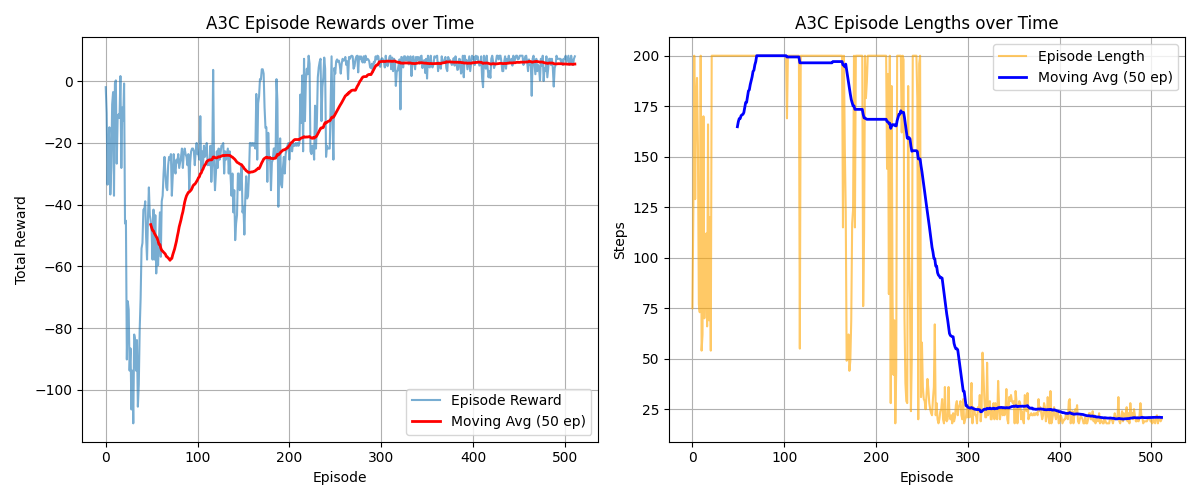

Okay, here is a concise analysis of the A3C learning curves:

**Analysis of A3C Learning Curves (Custom Grid World):**

1.  **Episode Rewards over Time (Left Plot):**
    The agent shows significant learning, with the moving average (red line) climbing steadily from highly negative rewards towards the optimal range (around 8) by episode ~300. The raw episode rewards (blue line) exhibit considerable variance, a common characteristic of A3C due to asynchronous updates from multiple actors leading to slightly decorrelated experiences and potentially noisier gradients than synchronous methods like A2C or PPO. Still, the overall trend is clearly positive and converges stably.

2.  **Episode Lengths over Time (Right Plot):**
    The episode length plot confirms the learning progress. Initially high and volatile (hitting the max steps frequently), the moving average (blue line) shows a sharp decrease, particularly between episodes ~150 and 300, eventually stabilizing near the optimal path length (~20 steps). The raw episode lengths (orange line) remain somewhat noisy but cluster tightly around the optimal value post-convergence, indicating efficient policy learning.

**Overall Conclusion:**
A3C successfully learns an effective and efficient policy for the Grid World task, as shown by the convergent reward and episode length curves. The asynchronous nature contributes to exploration and potentially faster wall-clock time on multi-core systems, but also introduces noticeable variance in the raw performance metrics compared to its synchronous counterpart (A2C) or methods with stronger policy constraints (PPO/TRPO).

# Analyzing the Learned Policy (Optional Visualization)

Visualize the policy learned by the *global* A3C actor network.

In [ ]:
# Reusing the policy plotting function
def plot_a3c_policy_grid(policy_net: ActorCriticNetwork, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the A3C Actor network component.
    Shows the most likely action for each state.
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    # Ensure model is on the correct device for inference
    policy_net.to(device) 
    policy_net.eval() # Set to evaluation mode

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                # Use the specific device for state tensor
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple).to(device)
                with torch.no_grad():
                    action_dist, _ = policy_net(state_tensor)
                    best_action: int = action_dist.probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("A3C Learned Policy (Most Likely Action)")
    plt.show()

# Plot the policy learned by the final global A3C actor
# Ensure the global model is accessible and potentially moved to eval device if needed
print("\nPlotting Learned Policy from Global A3C Model:")
plot_a3c_policy_grid(global_model_a3c, temp_env, device)

## Common Challenges and Solutions in A3C

**Challenge: Implementation Complexity (Multiprocessing)**
*   **Problem:** Correctly managing shared memory for the global network, handling shared optimizers (or the gradient passing mechanism), synchronizing workers, and collecting results requires careful use of multiprocessing libraries and can be prone to bugs (deadlocks, race conditions).
*   **Solutions**:
    *   **Use `torch.multiprocessing`:** Specifically designed to handle PyTorch tensors and models in parallel processes.
    *   **`.share_memory_()`:** Essential for making global model parameters accessible to workers.
    *   **Simplified Optimizer Approach:** Using local optimizers acting on shared parameters (as implemented here) avoids complex shared optimizer states but might be less efficient.
    *   **Thorough Testing:** Debugging multiprocessing code can be difficult.

**Challenge: Stale Gradients**
*   **Problem:** Because workers update asynchronously, a worker might compute gradients based on slightly outdated global parameters (parameters that have been updated by other workers since the local worker last synced). This can introduce noise or bias.
*   **Solutions**:
    *   **Generally Tolerated:** A3C's design relies on this effect for decorrelation; it often works well despite staleness.
    *   **Lower Learning Rates:** Can mitigate the impact of noisy/stale updates.
    *   **A2C/PPO:** Synchronous updates avoid stale gradients entirely.

**Challenge: Resource Utilization (CPU vs. GPU)**
*   **Problem:** A3C was designed for multi-core CPUs. While workers run efficiently on CPUs, applying gradients to a global model on a GPU requires data transfer and might not fully utilize the GPU if updates are too frequent and small. A2C often achieves better GPU utilization with batched updates.
   **Solutions**:
    *   **Run Global Model on CPU:** Simplifies implementation if workers are CPU-bound.
    *   **Optimize Data Transfer:** If using a GPU for the global model, ensure efficient handling of gradient transfers.
    *   **Consider A2C:** Often better suited for GPU-centric training.

**Challenge: Hyperparameter Tuning**
*   **Problem:** A3C has several sensitive hyperparameters, including the number of workers, n-step length, learning rates, and coefficients.
   **Solutions**:
    *   **N-step Length:** Balances bias (low n) and variance (high n). Common values range from 5 to 20.
    * **Number of Workers:** More workers increase data diversity but also potential for staleness. Often matched to CPU cores.
    * **Learning Rates:** Often need to be lower than synchronous methods.

## Conclusion

Asynchronous Advantage Actor-Critic (A3C) marked a significant development by successfully leveraging parallelism for stable and efficient reinforcement learning without relying on experience replay. Its core innovation lies in using multiple workers interacting with independent environment instances to generate diverse experiences and apply asynchronous updates to a shared global network, effectively decorrelating the data and stabilizing the learning process.

While its implementation complexity, potential for stale gradients, and often less optimal GPU utilization have led to the increased popularity of synchronous methods like A2C and PPO, A3C remains historically important. It demonstrated the power of asynchronous parallel training and influenced subsequent algorithm design. Understanding A3C provides valuable context for the evolution of actor-critic methods and the trade-offs between synchronous and asynchronous learning paradigms in RL.